In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import natsort

# pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_colwidth', 0)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

# KALLISTO

### pre-processing

In [2]:
expression = pd.read_table('/work/projects/ecosystem_biology/archaea/coevolution/analysis/mt_analysis/\
kallisto/uniq/expression_per_gene_and_condition/expression_all_genes_uniq.tsv')
expression = expression.iloc[natsort.index_humansorted(expression['gene'])]
expression

target_id diabetes gene  est_counts      tpm
0    M1.1-V2          yes      u1   1           55341  
1    M1.4-V2          yes      u1   63          254346 
2    M1.4-V3          yes      u1   1           470233 
3    M3.4-V2          yes      u1   12          60829  
4    M4.2-V3          yes      u1   9           210485 
..       ...          ...      ..  ..              ... 
114  M11.5-V3         no       u18  504         1000000
115  M11.6-V1         no       u18  1           1000000
127  M1.1-V1          yes      u20  3           432615 
128  M1.1-V2          yes      u20  4           346852 
129  M1.1-V3          yes      u20  4           572374 

[133 rows x 5 columns]

In [3]:
df = pd.DataFrame(expression.target_id.str.split('-').str[0])
expression['target_id'] = df

In [4]:
expression.groupby(['gene', 'diabetes', 'target_id'])\
.agg('mean').round(0)

est_counts        tpm
gene diabetes target_id                       
u1   no       M1.2       2.0         6535.0   
              M4.1       7.0         463184.0 
              M4.4       2.0         212180.0 
              M4.5       8.0         1000000.0
              M4.6       7.0         545150.0 
...                      ...               ...
u2   yes      M5.1       10.0        792690.0 
u20  yes      M1.1       4.0         450614.0 
u4   yes      M1.4       1.0         8081.0   
              M3.4       3.0         29495.0  
u7   yes      M2.1       2.0         61640.0  

[77 rows x 2 columns]

In [5]:
expression_processed = expression.groupby(['gene', 'diabetes', 'target_id'], as_index=False)\
.agg('mean').round(0)

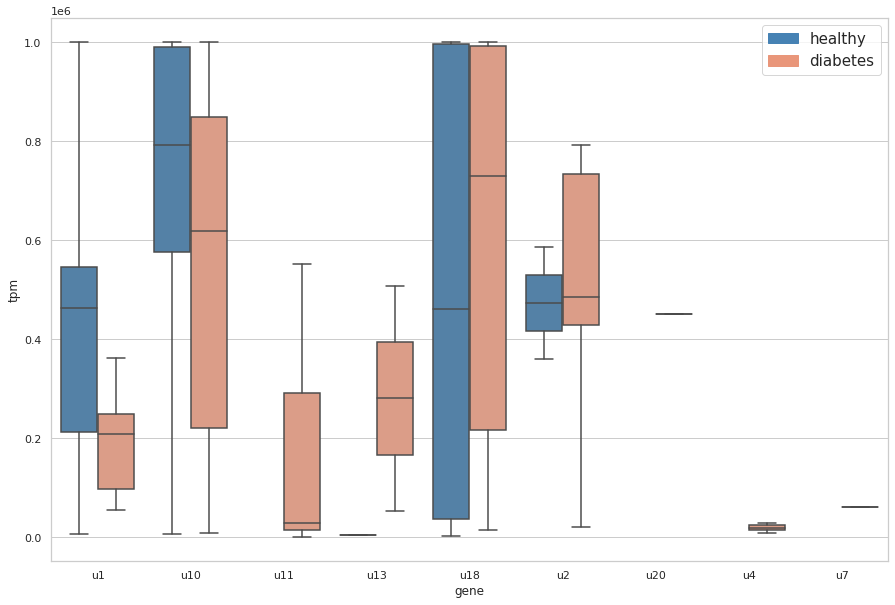

In [6]:
sns.set(style="whitegrid",
       rc={'figure.figsize':(15, 10)})

ax = sns.boxplot(x="gene", y="tpm", data=expression_processed, showfliers = False, hue='diabetes',
                palette = {"no": "steelblue", "yes": "darksalmon"})
# ax = sns.swarmplot(x="gene", y="tpm", data=expression_processed, color=".25")

no = mpatches.Patch(color='steelblue', label='healthy')
yes = mpatches.Patch(color='darksalmon', label='diabetes')
ax.legend(handles=[no, yes], fontsize=15)

In [7]:
tmp = expression_processed.drop_duplicates(['gene', 'diabetes'])\
.groupby(['gene'], as_index=False).agg({'diabetes':'count'})

expression_processed_dual = expression_processed[(expression_processed.gene.isin(tmp[tmp.diabetes>1].gene))]

# to replace manual:
# expression_processed_dual = expression_processed[~((expression_processed.gene == 'u11') 
#                                                    | (expression_processed.gene == 'u20') 
#                                                    | (expression_processed.gene == 'u4') 
#                                                    | (expression_processed.gene == 'u7'))]

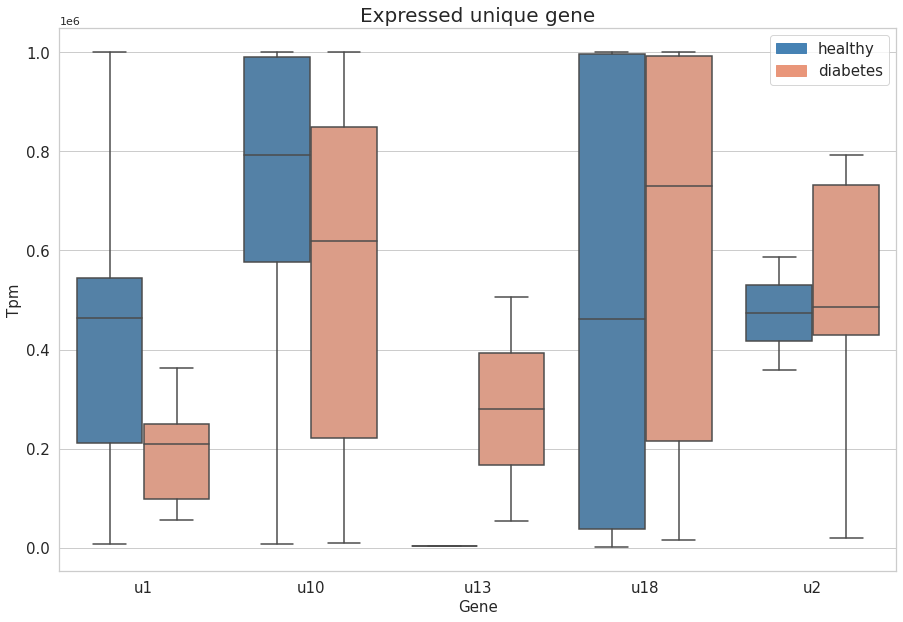

In [8]:
sns.set(style="whitegrid",
       rc={'figure.figsize':(15, 10)})

ax = sns.boxplot(x="gene", y="tpm", data=expression_processed_dual, 
             showfliers = False, hue='diabetes', palette = {"no": "steelblue", "yes": "darksalmon"})
# ax = sns.swarmplot(x="gene", y="tpm", data=expression_processed, color=".25")

ax.set_title('Expressed unique gene', fontsize = 20)
ax.set_xlabel('Gene', fontsize=15)
ax.set_ylabel('Tpm', fontsize=15)
ax.tick_params(labelsize=15)

no = mpatches.Patch(color='steelblue', label='healthy')
yes = mpatches.Patch(color='darksalmon', label='diabetes')
ax.legend(handles=[no, yes], fontsize=15)

#### Fisher's exact test

In [9]:
for v in expression_processed.gene.unique():
    exp_healthy = expression_processed[(expression_processed.gene == v) 
                                   & (expression_processed.diabetes == 'no')].shape[0]
    exp_disease = expression_processed[(expression_processed.gene == v) 
                                   & (expression_processed.diabetes == 'yes')].shape[0]
    
    data = [[exp_healthy, 18 - exp_healthy],
       [exp_disease, 17 - exp_disease]]
    
    print('for', v, "p_value: ", stats.fisher_exact(data)[1])
    

for u1 p_value:  0.7246718576195781
for u10 p_value:  0.2889877641824252
for u11 p_value:  0.10389610389610375
for u13 p_value:  0.6025974025974019
for u18 p_value:  1.0
for u2 p_value:  0.22847608453837576
for u20 p_value:  0.4857142857142858
for u4 p_value:  0.22857142857142845
for u7 p_value:  0.4857142857142858


Manual check:

In [10]:
exp_healthy = expression_processed[(expression_processed.gene == 'u18') 
                                   & (expression_processed.diabetes == 'no')].shape[0]

exp_disease = expression_processed[(expression_processed.gene == 'u18') 
                                   & (expression_processed.diabetes == 'yes')].shape[0]

data = [[exp_healthy, 18 - exp_healthy],
       [exp_disease, 17 - exp_disease]]
print (data)
print("p_value: ", stats.fisher_exact(data)[1])

[[13, 5], [12, 5]]
p_value:  1.0


In [11]:
expression_processed[expression_processed.gene == 'u18']\
.groupby(['gene', 'diabetes', 'target_id'])\
.agg({'target_id':'count'})

target_id
gene diabetes target_id           
u18  no       M1.2       1        
              M1.3       1        
              M11.4      1        
              M11.5      1        
              M11.6      1        
              M3.3       1        
              M4.1       1        
              M4.4       1        
              M4.6       1        
              M5.3       1        
              M6.4       1        
              M8.2       1        
              M8.3       1        
     yes      M1.1       1        
              M11.1      1        
              M11.3      1        
              M2.2       1        
              M2.3       1        
              M3.4       1        
              M4.2       1        
              M4.3       1        
              M5.4       1        
              M6.2       1        
              M6.3       1        
              M8.1       1

#### Wilcoxon test

In [12]:
gene = 'u18'
select = expression_processed_dual[expression_processed_dual.gene == gene]

stats.ranksums(select[select.diabetes == 'yes'][['tpm']], select[select.diabetes == 'no'][['tpm']])

RanksumsResult(statistic=0.3535533905932738, pvalue=0.7236736098317631)

In [13]:
expression_processed.groupby(['gene'], as_index=False)\
.agg('mean').round(0).sort_values('tpm', ascending=False)

gene  est_counts       tpm
1  u10  326.0       624114.0
4  u18  67.0        572152.0
5  u2   12.0        486669.0
6  u20  4.0         450614.0
0  u1   9.0         307797.0
2  u11  4.0         193987.0
3  u13  21.0        188105.0
8  u7   2.0         61640.0 
7  u4   2.0         18788.0

# HOMO

In [14]:
expression_v0 = pd.read_table('/work/projects/ecosystem_biology/archaea/coevolution/analysis/mt_analysis/kallisto/homo/expression_per_gene_and_condition/expression_all_genes_homo.tsv')
expression = expression_v0.iloc[natsort.index_humansorted(expression_v0['gene'])]
expression

target_id gene  est_counts       tpm
1    M3.4-V2          h1   24.99000    55931.5 
107  M2.1-V1          h2   1.99034     189072.0
285  M2.1-V2          h5   1.00000     27873.3 
286  M5.4-V3          h5   1.00000     216512.0
287  M11.4-V1         h5   2.00000     37589.0 
..               ...  ..       ...         ... 
280  M4.6-V3          h39  31.00000    86046.8 
281  M5.1-V1          h39  9.00000     38672.4 
282  M11.6-V1         h39  22.00000    257923.0
283  M11.6-V2         h39  7.00000     248066.0
284  M11.6-V3         h39  5.00000     58813.4 

[313 rows x 4 columns]

In [15]:
metadata = pd.read_table('/work/projects/ecosystem_biology/archaea/coevolution/analysis/mt_analysis/metadata.tsv')

In [16]:
df = pd.DataFrame(expression.target_id.str.split('-').str[0])
expression['target_id'] = df

In [17]:
expression = expression.merge(metadata)

In [18]:
expression_processed = expression.groupby(['gene', 'diabetes', 'target_id'], as_index=False)\
.agg('mean').round(0)

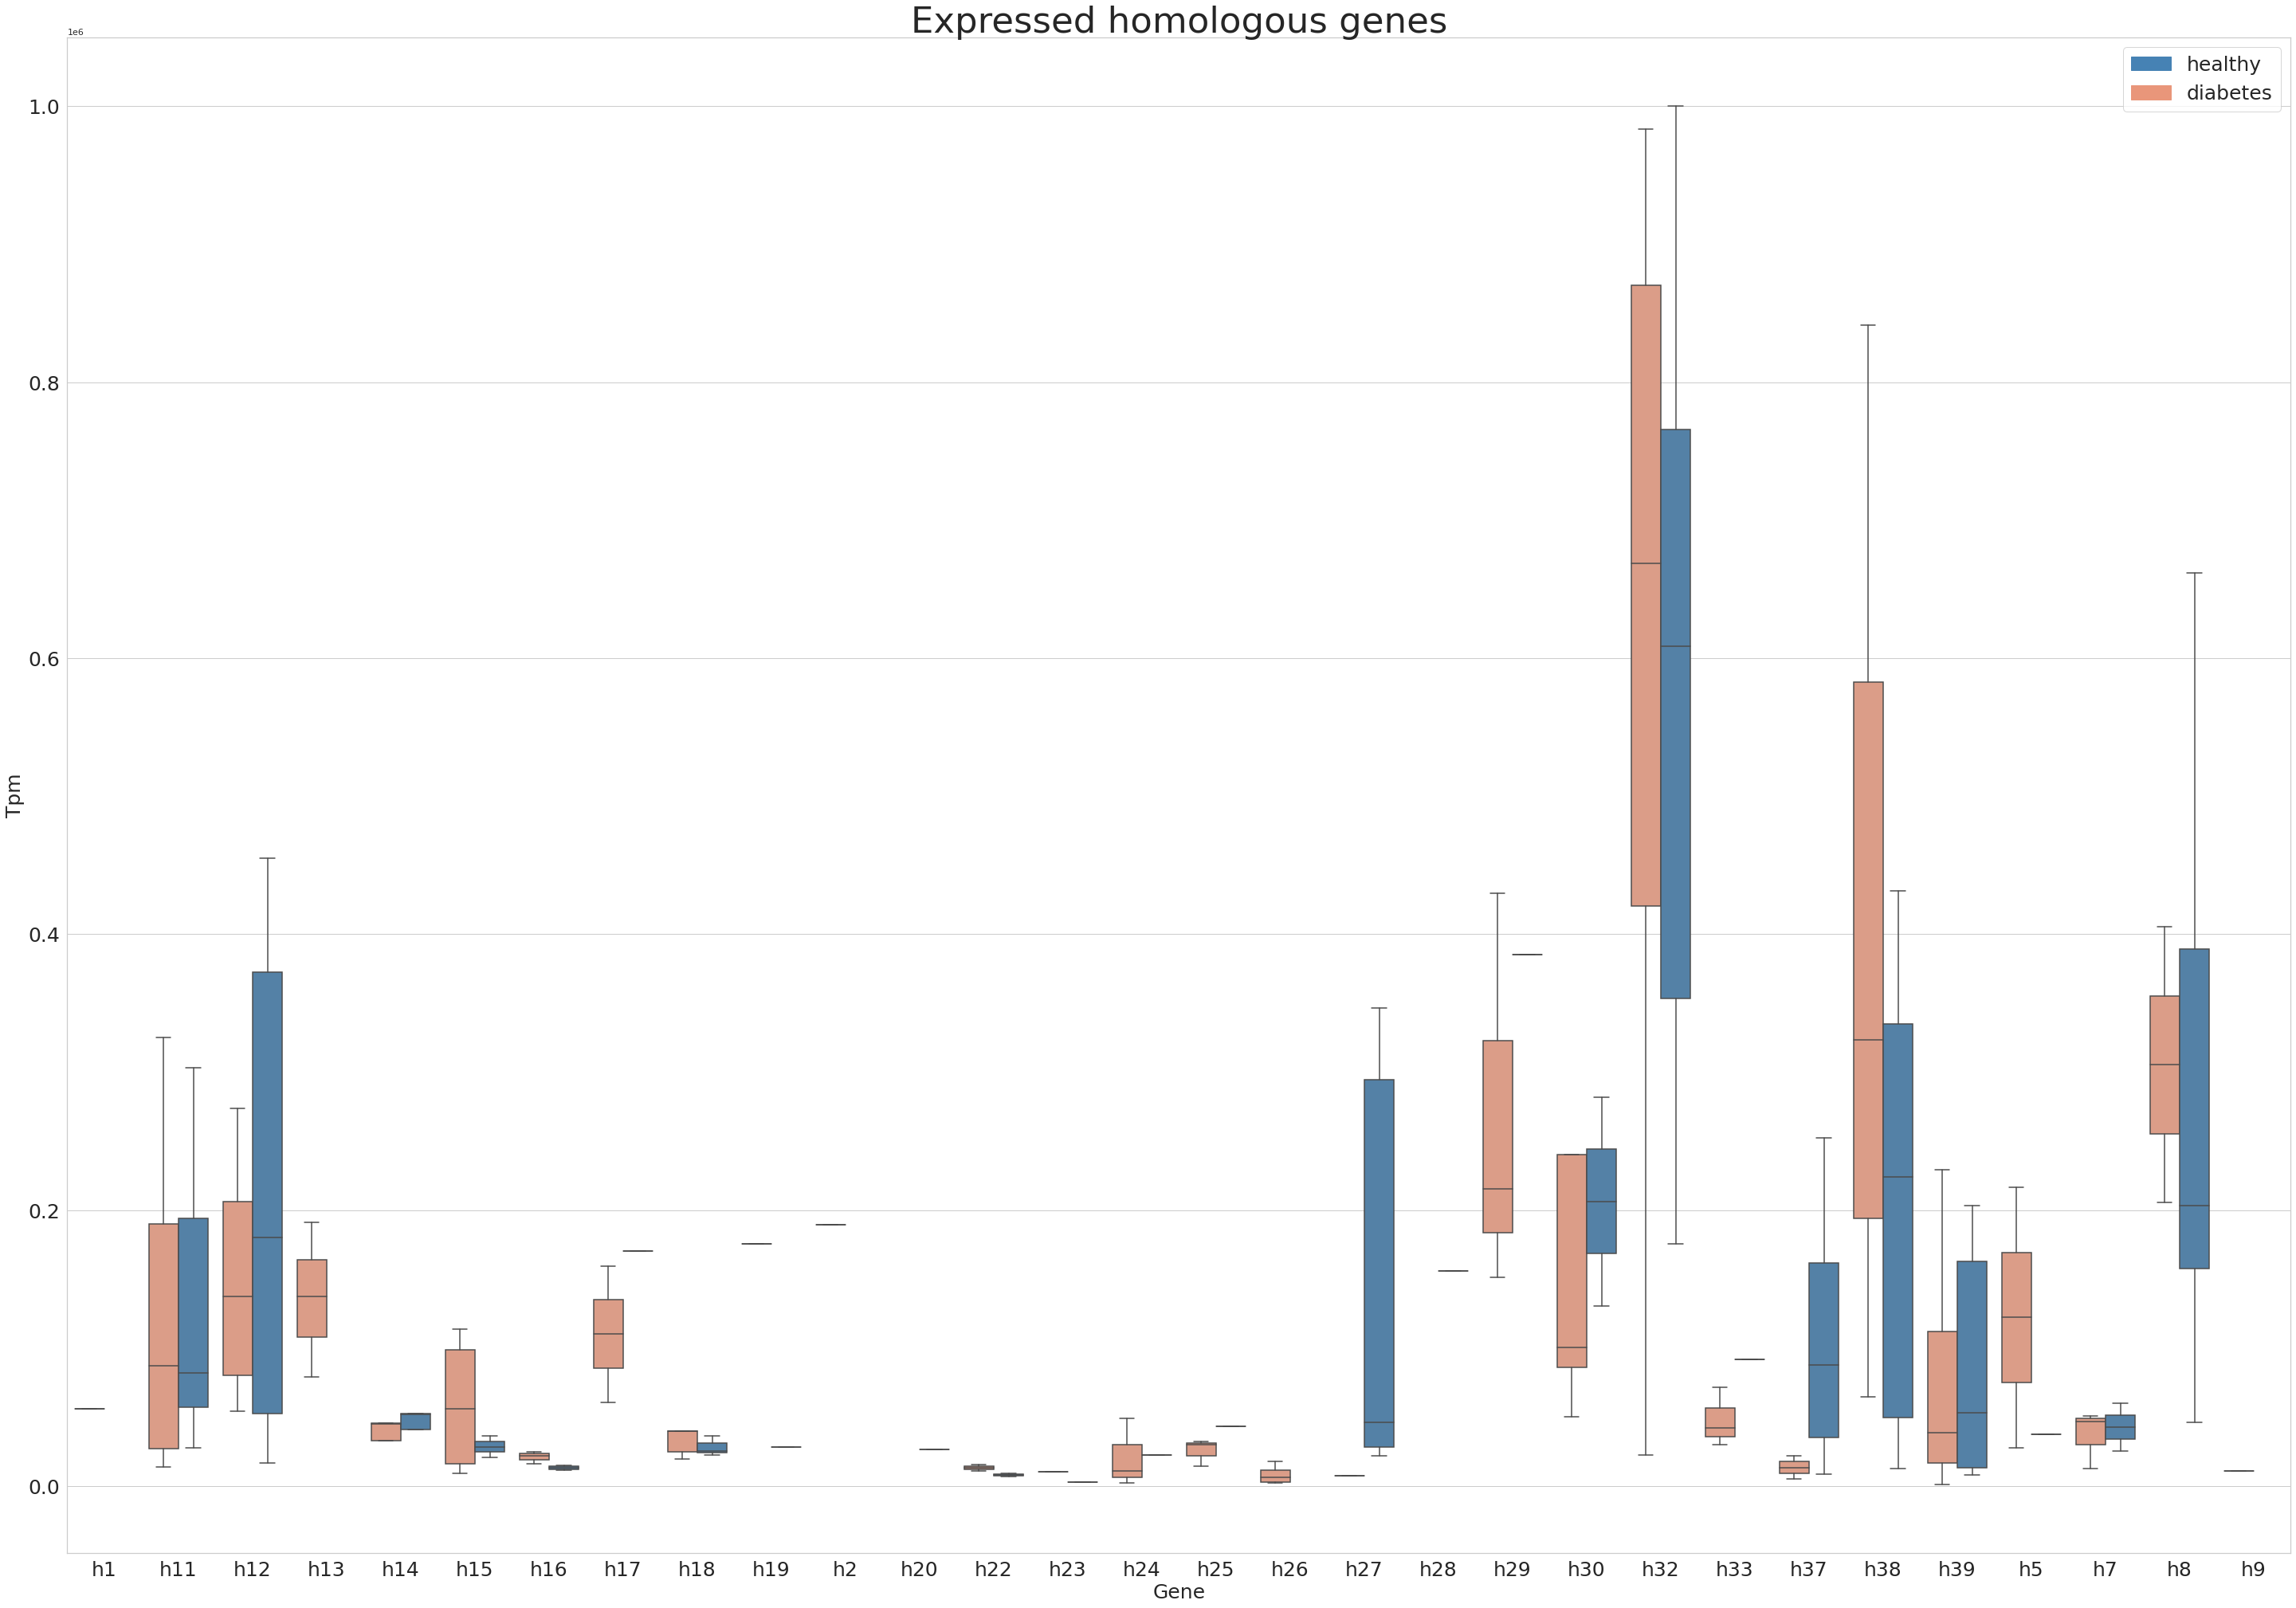

In [19]:
sns.set(style="whitegrid",
       rc={'figure.figsize':(50, 35)})

ax = sns.boxplot(x="gene", y="tpm", data=expression_processed, showfliers = False, hue='diabetes',
                palette = {"no": "steelblue", "yes": "darksalmon"})
# ax = sns.swarmplot(x="gene", y="tpm", data=expression_processed, color=".25")
# ax.set_title('u18', fontsize = 25)
ax.set_title('Expressed homologous genes', fontsize = 45)
ax.set_xlabel('Gene', fontsize=25)
ax.set_ylabel('Tpm', fontsize=25)
ax.tick_params(labelsize=25)

no = mpatches.Patch(color='steelblue', label='healthy')
yes = mpatches.Patch(color='darksalmon', label='diabetes')
ax.legend(handles=[no, yes], fontsize=25)

In [20]:
tmp = expression_processed.drop_duplicates(['gene', 'diabetes'])\
.groupby(['gene'], as_index=False).agg({'diabetes':'count'})

expression_processed_dual = expression_processed[(expression_processed.gene.isin(tmp[tmp.diabetes>1].gene))]

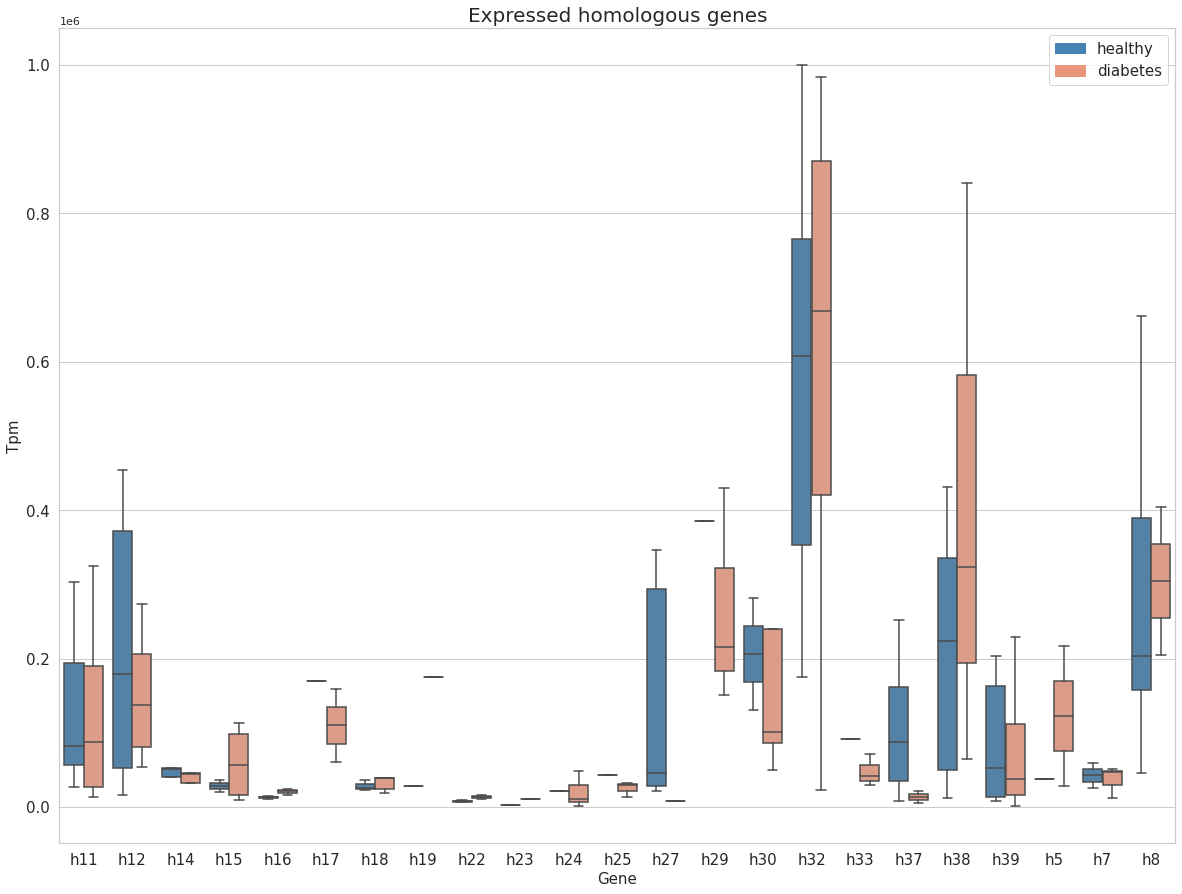

In [21]:
sns.set(style="whitegrid",
       rc={'figure.figsize':(20, 15)})

ax = sns.boxplot(x="gene", y="tpm", data=expression_processed_dual, 
             showfliers = False, hue='diabetes', palette = {"no": "steelblue", "yes": "darksalmon"})
# ax = sns.swarmplot(x="gene", y="tpm", data=expression_processed, color=".25")

ax.set_title('Expressed homologous genes', fontsize = 20)
ax.set_xlabel('Gene', fontsize=15)
ax.set_ylabel('Tpm', fontsize=15)
ax.tick_params(labelsize=15)

# ax.legend(fontsize=15)

no = mpatches.Patch(color='steelblue', label='healthy')
yes = mpatches.Patch(color='darksalmon', label='diabetes')
ax.legend(handles=[no, yes], fontsize=15)

#### Wilcoxon test

In [22]:
gene = 'h26'
select = expression_processed_dual[expression_processed_dual.gene == gene]

stats.ranksums(select[select.diabetes == 'yes'][['tpm']], select[select.diabetes == 'no'][['tpm']])

/home/users/pnovikova/miniconda3/envs/jupyter_conda_test/lib/python3.8/site-packages/scipy/stats/stats.py:6475: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


RanksumsResult(statistic=nan, pvalue=nan)

#### Fisher's exact test

In [23]:
for v in expression_processed.gene.unique():
    exp_healthy = expression_processed[(expression_processed.gene == v) 
                                   & (expression_processed.diabetes == 'no')].shape[0]
    exp_disease = expression_processed[(expression_processed.gene == v) 
                                   & (expression_processed.diabetes == 'yes')].shape[0]
    
    data = [[exp_healthy, 18 - exp_healthy],
       [exp_disease, 17 - exp_disease]]
    
    print('for', v, "p_value: ", stats.fisher_exact(data)[1])
    

for h1 p_value:  0.4857142857142858
for h11 p_value:  0.4997920394641385
for h12 p_value:  0.3175386015456987
for h13 p_value:  0.10389610389610375
for h14 p_value:  1.0
for h15 p_value:  0.40175953079178783
for h16 p_value:  0.658148303309594
for h17 p_value:  0.6025974025974019
for h18 p_value:  0.44301749418545877
for h19 p_value:  1.0
for h2 p_value:  0.4857142857142858
for h20 p_value:  1.0
for h22 p_value:  1.0
for h23 p_value:  1.0
for h24 p_value:  0.33766233766233766
for h25 p_value:  0.33766233766233766
for h26 p_value:  0.045454545454545546
for h27 p_value:  0.17741935483870924
for h28 p_value:  1.0
for h29 p_value:  0.33766233766233766
for h30 p_value:  0.40175953079178783
for h32 p_value:  0.4857142857142858
for h33 p_value:  0.33766233766233766
for h37 p_value:  0.6581483033095924
for h38 p_value:  0.4430174941854596
for h39 p_value:  0.49979203946413836
for h5 p_value:  0.6025974025974019
for h7 p_value:  0.658148303309594
for h8 p_value:  0.12120537971483483
for h9 p_va

Manual check:

In [24]:
exp_healthy = expression_processed[(expression_processed.gene == 'h26') 
                                   & (expression_processed.diabetes == 'no')].shape[0]

exp_disease = expression_processed[(expression_processed.gene == 'h26') 
                                   & (expression_processed.diabetes == 'yes')].shape[0]

data = [[exp_healthy, 18 - exp_healthy],
       [exp_disease, 17 - exp_disease]]
print (data)
print("p_value: ", stats.fisher_exact(data)[1])

[[0, 18], [4, 13]]
p_value:  0.045454545454545546


In [25]:
expression_v0[expression_v0.gene == 'h26']

target_id gene  est_counts       tpm
133  M1.1-V3   h26  1.0         9113.13 
134  M1.4-V2   h26  4.0         2211.09 
135  M3.4-V2   h26  4.0         17848.40
136  M3.5-V1   h26  1.0         2969.07

In [26]:
expression_v0[expression_v0.target_id.str.startswith('M1.4-V2')]

target_id gene  est_counts         tpm
60   M1.4-V2   h14  99.00000    31680.800 
73   M1.4-V2   h15  13.28130    9111.080  
83   M1.4-V2   h16  6.36364     4365.500  
91   M1.4-V2   h17  32.71870    55661.300 
98   M1.4-V2   h18  28.63640    19644.700 
114  M1.4-V2   h22  116.00000   6467.930  
129  M1.4-V2   h25  17.00000    14179.600 
134  M1.4-V2   h26  4.00000     2211.090  
147  M1.4-V2   h29  18.69960    97224.900 
154  M1.4-V2   h30  10.30040    103247.000
167  M1.4-V2   h32  1.00000     732.033   
234  M1.4-V2   h33  23.00000    41935.800 
267  M1.4-V2   h39  2555.00000  567847.000
292  M1.4-V2   h7   31.00000    35001.300 
312  M1.4-V2   h9   5.00000     10689.200

In [27]:
expression_processed.groupby(['gene'], as_index=False)\
.agg('mean').round(0).sort_values('tpm', ascending=False)

gene  est_counts       tpm
21  h32  55.0        584236.0
19  h29  7.0         295360.0
28  h8   15.0        290630.0
24  h38  20.0        276092.0
20  h30  3.0         219047.0
2   h12  10.0        213460.0
10  h2   2.0         189072.0
18  h28  7.0         155752.0
3   h13  14.0        135814.0
7   h17  10.0        130229.0
1   h11  6.0         125265.0
17  h27  8.0         124106.0
25  h39  109.0       104201.0
9   h19  1.0         101724.0
26  h5   1.0         93991.0 
23  h37  2.0         77208.0 
22  h33  8.0         58727.0 
0   h1   25.0        55932.0 
8   h18  6.0         54662.0 
5   h15  6.0         48679.0 
4   h14  14.0        46336.0 
27  h7   5.0         39151.0 
15  h25  6.0         29879.0 
11  h20  2.0         26653.0 
14  h24  38.0        20969.0 
6   h16  3.0         17884.0 
29  h9   5.0         10689.0 
12  h22  23.0        10624.0 
16  h26  2.0         8035.0  
13  h23  6.0         6564.0